# Clustering com Dados do Cartola FC

## 1.0 Dataset

Foram utilizados dados do Cartola FC obtido através do seguinte [respositório](https://github.com/henriquepgomide/caRtola) do GitHub. O CSV utilizado foi o "dados_agregados_limpos.csv", o qual é a junção dos dados dos anos de 2014 a 2018, além de serem dados já tratados sem a presença de NaN. A limpeza realizada é descrita [aqui](https://github.com/henriquepgomide/caRtola/blob/master/src/python/An%C3%A1lise%20dos%20Dados.ipynb).

Cada linha apresenta dados dos jogadores obtidos em uma determinada rodada. Colunas relevantes:
- Rodada: número da rodada do Brasileirão
- ClubeID: clube do jogador
- AtletaID: id do jogador
- Posicao: posição do jogador
- Pontos: pontuação do jogador
- PontosMedia: média da pontuação do jogador
- FS: faltas sofridas
- PE: passes errados
- A: assistências
- FT: finalizações na trave
- FD: finalizações defendidas
- FF: finalizações para fora
- G: gols
- I: impedimentos
- FC: faltas cometidas
- CA: cartões amarelo
- CV: cartões vermelho
- SG: jogos sem sofrer gols
- GS: gols sofridos
- RB: roubadas de bola
- DD: defesas difíceis
- DP: defesas de pênalti

Primeiro, será clusterizado em três grupos os jogadores, o agrupamento será feito separadamente para cada posição (goleiro, zagueiro, atacante, lateral e meia). Dessa forma, ao final, teremos trẽs grupos de goleiros, três grupos de zagueiro e assim sucessivamente.

Após essa primeira etapa, será feito a estimativa de quais jogadores seriam bons para serem escalados, de acordo com o seus perfis. Isso será explicado mais detalhadamente no item 4.0.

In [2]:
import pandas as pd
import numpy as np

dados_agregados = pd.read_csv('dados_agregados_limpos.csv')
dados_agregados.shape

(17567, 77)

In [3]:
dados_agregados.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


## 2.0 Explorando os dados

### 2.1 Tipos de posição e a quantidade:

In [4]:
dados_agregados.Posicao.value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

### 2.2 Descrição das colunas

In [5]:
colunas = ['Pontos','PontosMedia','FS','PE','A','FT','FF','FC',
           'FD','G','I','RB','CA','CV','SG','DD','DP','GS']

dados_agregados[colunas].describe()

,Pontos,PontosMedia,FS,PE,A,FT,FF,FC,FD,G,I,RB,CA,CV,SG,DD,DP,GS
count,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000
mean,2.946798,2.960628,1.111914,2.315763,0.064325,0.018102,0.347356,1.159845,0.241305,0.090169,0.136847,1.026015,0.169693,0.008140,0.124039,0.115671,0.002505,0.090169
std,4.344379,2.050958,1.304447,2.042131,0.262381,0.135862,0.644317,1.260528,0.538621,0.315378,0.440791,1.265575,0.375980,0.090489,0.329636,0.552542,0.051112,0.435866
min,-10.500000,-8.400000,-3.000000,-6.000000,-1.000000,0.000000,-1.000000,-2.000000,-2.000000,0.000000,-1.000000,-4.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.680000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.880000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.200000,4.090000,2.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.000000,21.830000,12.000000,14.000000,4.000000,2.000000,7.000000,10.000000,6.000000,3.000000,7.000000,9.000000,1.000000,1.000000,1.000000,7.000000,2.000000,6.000000


### 2.3 Tratar dados duplicados

A problemática é a repetição do valor "AtletaID" nas linhas do dataset, visto que um atleta pode ter participado de várias partidas. Para resolver esse problema, será calculada a média das colunas a serem utilizadas.

In [0]:
dados = dados_agregados.copy()
# filtrando apenas as colunas que serão usadas
dados = dados[['ClubeID','AtletaID','Posicao','Pontos','FS','PE','A','FT','FF','FC',
           'FD','G','I','RB','CA','CV','SG','DD','DP','GS']]

Nas análises abaixo estamos:
- conferindo se AtletaID só tem um tipo de posição;
- se o AtletaID participou de mais de um ClubeID.

In [7]:
display(dados.groupby(['AtletaID']).Posicao.unique().reset_index().head(10))

display(dados.groupby(['AtletaID']).ClubeID.unique().reset_index().head(10))

,AtletaID,Posicao
0,36540,[zag]
1,36612,[lat]
2,37604,[zag]
3,37607,"[lat, mei]"
4,37608,[mei]
5,37623,[zag]
6,37644,[zag]
7,37646,[zag]
8,37652,[mei]
9,37653,[ata]


,AtletaID,ClubeID
0,36540,"[Internacional, Flamengo]"
1,36612,"[Grêmio, Palmeiras]"
2,37604,[Atlético-PR]
3,37607,"[São Paulo, Palmeiras]"
4,37608,[Grêmio]
5,37623,[Vasco]
6,37644,[Ponte Preta]
7,37646,[Avaí]
8,37652,"[Botafogo, Figueirense, Atlético-PR]"
9,37653,"[Internacional, Santos]"


Como alguns AtletaID estão relacionados com mais de uma tipo de posição e a mais de um Clube, os dados serão agrupados por AtletaID e Posicao, dessa forma, será obtida a média de um determinado jogador envolvendo apenas os pontos de uma das posições dele. Por exemplo, jogador A possui as posições de zagueiro e de lateral, os pontos obtidos com a posição de zagueiro serão utilizados apenas para o cálculo das médias de zagueiro e os pontos da posição lateral, serão usados apenas para as médias de lateral.

In [8]:
df_mean = dados.groupby(['AtletaID','Posicao']).mean().reset_index()
df_mean.head()

,AtletaID,Posicao,Pontos,FS,PE,A,FT,FF,FC,FD,G,I,RB,CA,CV,SG,DD,DP,GS
0,36540,zag,4.095349,0.627907,1.418605,0.069767,0.023256,0.441860,0.860465,0.186047,0.000000,0.000000,1.348837,0.279070,0.000000,0.395349,0.0,0.0,0.0
1,36612,lat,2.895588,1.088235,1.705882,0.147059,0.000000,0.191176,0.926471,0.073529,0.014706,0.102941,1.441176,0.176471,0.000000,0.044118,0.0,0.0,0.0
2,37604,zag,1.711111,0.611111,2.277778,0.000000,0.055556,0.000000,0.777778,0.111111,0.000000,0.000000,0.722222,0.222222,0.000000,0.277778,0.0,0.0,0.0
3,37607,lat,2.642424,0.424242,3.090909,0.242424,0.000000,0.575758,0.969697,0.454545,0.060606,0.393939,0.606061,0.151515,0.060606,0.212121,0.0,0.0,0.0
4,37607,mei,2.300000,0.785714,2.857143,0.142857,0.000000,0.857143,0.785714,0.214286,0.000000,0.214286,1.357143,0.285714,0.000000,0.000000,0.0,0.0,0.0


### 2.4 Seleção das posições dos jogadores e caractéristicas relevantes

Abaixo é feita a filtragem de acordo com a posição dos jogadores e é executado a seleção das colunas (dados) para a cada posição.

O critério usado será o da variância, quando determinada características tem uma variância considerada relevante (>0.001), ela será levada em conta na clusterização.

In [0]:
dados_meia = df_mean[df_mean['Posicao']=='mei']
features_meia = dados_meia.var()[dados_meia.var().values > 0.001].keys()
dados_meia = dados_meia[features_meia]

dados_atacante = df_mean[df_mean['Posicao']=='ata']
features_atacante = dados_atacante.var()[dados_atacante.var().values > 0.001].keys()
dados_atacante = dados_atacante[features_atacante]

dados_lateral = df_mean[df_mean['Posicao']=='lat']
features_lateral = dados_lateral.var()[dados_lateral.var().values > 0.001].keys()
dados_lateral = dados_lateral[features_lateral]

dados_zaga = df_mean[df_mean['Posicao']=='zag']
features_zaga = dados_zaga.var()[dados_zaga.var().values > 0.001].keys()
dados_zaga = dados_zaga[features_zaga]

dados_gol = df_mean[df_mean['Posicao']=='gol']
features_gol = dados_gol.var()[dados_gol.var().values > 0.001].keys()
dados_gol = dados_gol[features_gol]

## 3.0 Clusterização das posições

Será utilizada o algoritmo k-means clustering para dividir as posições dos jogadores em clusters, esse algoritmo usa a distância euclidiana para formar clusters de posições que são semelhantes. Para isso, será utilizada a classe KMeans do scikit-learn.

A inicialização dos modelos será feita da seguinte forma:

```python
kmeans_model = KMeans(n_clusters=3, random_state=1)
```
Onde o número de clusters é igual a 3 (três) com um estado aleatório igual a 1.

In [0]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 3.1 Atacante

No gráfico abaixo, há a representação da localização dos atacantes e os agrupamentos resultantes do k-means.

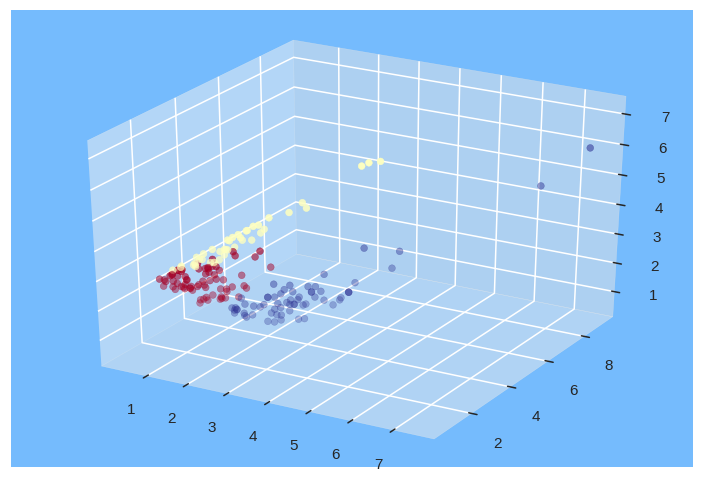

In [11]:
kmeans_atacante = KMeans(n_clusters=3, random_state=1)

distancias_ata = kmeans_atacante.fit_transform(dados_atacante.iloc[:,1:])

labels_ata = kmeans_atacante.labels_

dados_atacante['cluster'] = labels_ata

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_ata[:,0]
ys = distancias_ata[:,1]
zs = distancias_ata[:,2]
ax.scatter(xs, ys, zs, c=labels_ata, cmap="RdYlBu")

plt.show()

Acima é mostrado o "distancias_ata", o qual retorna um NumPy com três colunas. A primeira coluna é a distância euclidiana de cada jogador até o primeiro cluster, a segunda coluna é a distância euclidiana de cada jogador até o segundo cluster e a terceira coluna é a distância euclidiana de cada jogador até o terceiro cluster. Essa mesma lógica vale para as seguintes clusterizações.

### 3.2 Zagueiro

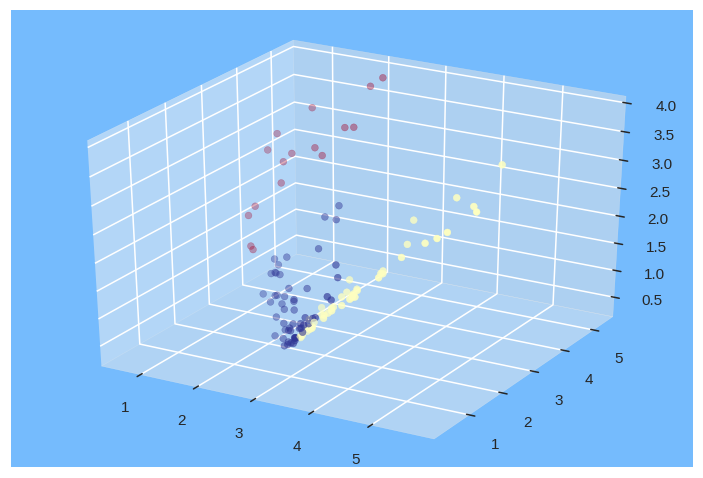

In [12]:
kmeans_zaga = KMeans(n_clusters=3, random_state=1)

distancias_zag = kmeans_zaga.fit_transform(dados_zaga.iloc[:,1:])

labels_zag = kmeans_zaga.labels_

dados_zaga['cluster'] = labels_zag

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_zag[:,0]
ys = distancias_zag[:,1]
zs = distancias_zag[:,2]
ax.scatter(xs, ys, zs, c=labels_zag, cmap="RdYlBu")

plt.show()

### 3.3 Lateral

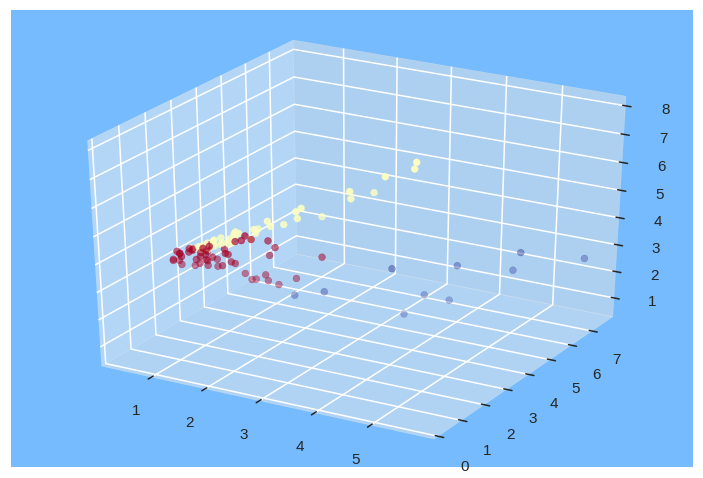

In [13]:
kmeans_lat = KMeans(n_clusters=3, random_state=1)

distancias_lateral = kmeans_lat.fit_transform(dados_lateral.iloc[:,1:])

labels_lat = kmeans_lat.labels_

dados_lateral['cluster'] = labels_lat

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_lateral[:,0]
ys = distancias_lateral[:,1]
zs = distancias_lateral[:,2]
ax.scatter(xs, ys, zs, c=labels_lat, cmap="RdYlBu")

plt.show()

### 3.4 Meia

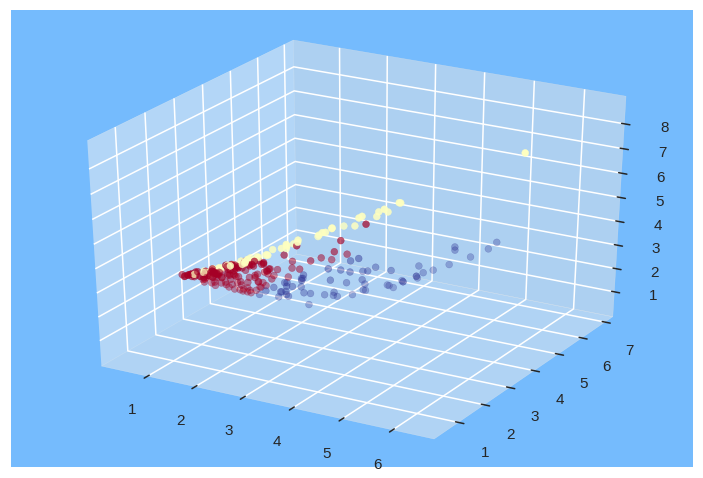

In [14]:
kmeans_meia = KMeans(n_clusters=3, random_state=1)

distancias_meia = kmeans_meia.fit_transform(dados_meia.iloc[:,1:])
  
labels_meia = kmeans_meia.labels_

dados_meia['cluster'] = labels_meia

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_meia[:,0]
ys = distancias_meia[:,1]
zs = distancias_meia[:,2]
ax.scatter(xs, ys, zs, c=labels_meia, cmap="RdYlBu")

plt.show()

### 3.5 Goleiro

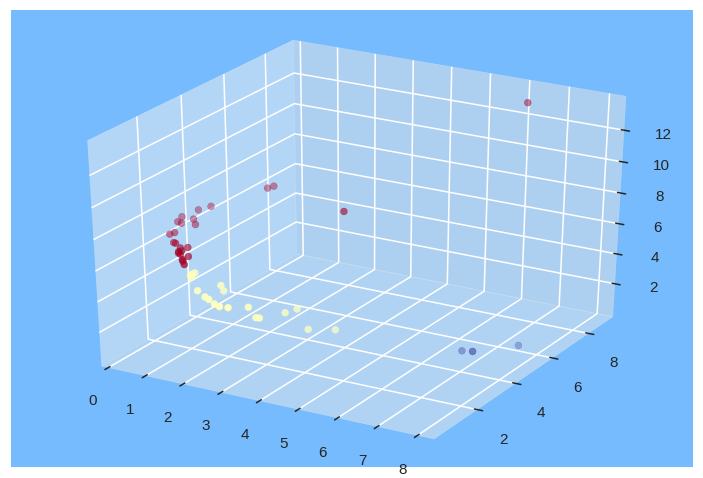

In [15]:
kmeans_gol = KMeans(n_clusters=3, random_state=1)

distancias_gol = kmeans_gol.fit_transform(dados_gol.iloc[:,1:])

labels_gol = kmeans_gol.labels_

dados_gol['cluster'] = labels_gol

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_gol[:,0]
ys = distancias_gol[:,1]
zs = distancias_gol[:,2]
ax.scatter(xs, ys, zs, c=labels_gol, cmap="RdYlBu")

plt.show()

## 4.0 Confronto

Com os clusters estabelecidos, o objetivo é estimar quais seriam jogadores bons para serem escalados em cada posição, de acordo com o seus perfis. Para tal, foi pensando em uma forma de confronto, a qual consiste em analisar o desempenho da dada posição em relação a posição de enfrentamento direta em jogo.

A distribuição dos possíveis confrontos foi feita com base em uma situação real de jogo, onde um atacante tem mais contato direto contra zagueiros do time adversário. Assim, para estimar possíveis atacantes bons, é analisado quais os tipos de zagueiros do time a ser enfrentado e seus respectivos clusters, pois a estimativa de desempenho é feita com os dados do atacante contra todos os zagueiros dos clusters selecionados.

Abaixo há um fluxograma de como se dá o processo de confronto entre os times:

<center>
![alt text](https://ia801502.us.archive.org/20/items/image_20181116/image.png)




Onde **MConf** significa a média dos pontos obtidos no confronto com o cluster, **MCamp** é a média no campeonato e **Mult5** é a média das últimas 5 rodadas.

Pode-se tomar como exemplo, o ataque do time do Fluminense. A pergunta é, dada uma rodada do campeonato brasileiro da série A, na qual o time do Fluminense enfretará a defesa do Grêmio, qual melhor atacante do Fluminense a ser escalado?

Para tal foram usados os dados do ano de 2017:

In [0]:
# datasets necessário para o cruzamento dos times
partidas_2017 = pd.read_csv('2017_partidas.csv')
times_ids = pd.read_csv('times_ids.csv')
times_2017 = pd.read_csv('2017_times.csv', delimiter=';')

Inicialmente foi criada a função **select_jogadores_time_posicao_ano**, onde são selecionados os jogadores do time, na posição e no ano informados.

In [0]:
# retorna os jogadores dos requisitos time, posição e ano
def select_jogadores_time_posicao_ano(time, posicao, ano):
  return dados_agregados[dados_agregados['ano'] == ano ][dados_agregados['ClubeID'] == time][dados_agregados['Posicao'] == posicao]

Escolhido o time em que se deseja saber a estimativa de pontos e o time adversário, é necessário saber em quais rodadas esses times se enfrentaram anteriormente, para assim, obter as informações de quais jogadores na posição oposta estavam atuando naquela respectiva rodada, e suas pontuações. Para serem retornada as rodadas, foi criada a função **rodada**.

In [0]:
# essa função retorna as rodadas (numeros inteiros) em que os times passados irão se enfrentear
def rodada(time1, time2):
  
  time1 = times_ids[times_ids['nome.cartola'] == time1]
  time2 = times_ids[times_ids['nome.cartola'] == time2]

  casa = partidas_2017[partidas_2017['home_team'] == time1['nome.cbf'].values[0]]
  fora = partidas_2017[partidas_2017['away_team'] == time1['nome.cbf'].values[0]]

  rodada_casa = casa[casa['away_team'] == time2['nome.cbf'].values[0]]['round'].values[0]
  
  # como o campeonato possui 20 equipes e se baseia em um confronto todos contra todos, em partidas de ida e volta
  # o valor da rodada do segundo turno tambem poderia ser encontrada somando-se 19 no valor da primeira rodada.
  # rodada_fora = rodada_casa + 19
  rodada_fora = fora[fora['home_team'] == time2['nome.cbf'].values[0]]['round'].values[0]
  ambas = [rodada_casa, rodada_fora]
  
  return ambas



Em seguida, é criada a função **desempenho_rodada_contra**, sendo necessário um dataset e o par de rodadas para obter o desempenho médio daqueles jogadores nas respectivas jogadas, ou seja, dado o conjunto de jogadores e as rodadas, a função retorna a média de pontos nas duas rodadas.

In [0]:
# retona o desempenho daqueles jogadores nas rodadas passadas
def desempenho(data1, rodadas):
  desemp_1 = data1[data1['Rodada'] == rodadas[0]][dados_agregados['Participou'] == True]
  desemp_1 = desemp_1[['Apelido', 'Posicao', 'AtletaID', 'ClubeID', 'Pontos', 'Rodada']]
  
  desemp_2 = data1[data1['Rodada'] == rodadas[1]][dados_agregados['Participou'] == True]
  desemp_2 = desemp_2[['Apelido', 'Posicao', 'AtletaID', 'ClubeID', 'Pontos', 'Rodada']]
  
  desempenho = pd.concat([desemp_1, desemp_2])
  desempenho = desempenho.groupby(['AtletaID', 'Posicao', 'Apelido', 'ClubeID', 'Rodada']).mean().reset_index()

  return desempenho

A função **clusters_contra** retorna os clusters no qual se encontram os jogadores da posição escolhida como opositora, para que posteriormente seja feita a análise contra todos os jogadores do cluster retornado.

In [0]:
# retorna os clusters no qual o data passado pertence
# dados os jogadores que forem escolhidos para se ter como confrontados, as rodadas e dataset em que
# se tem a informação de quais cluster eles estão.
def clusters_contra(data_contra, rods, data_posi_contra):
  clusters = []
  
  for i in rods:
    contra = data_contra[data_contra['Rodada'] == i][dados_agregados['Participou'] == True]

    for x in range(0, len(contra)):
      clusters.append(int(data_posi_contra[data_posi_contra.AtletaID == contra.AtletaID.values[x]].cluster))

  clusters = np.unique(clusters) 
  return clusters

Por final, a função **desempenho_ccluster** retorna o desempenho geral dos jogadores escolhidos em relação ao cluster em que os jogadores opositores estão.

In [0]:
# retorna o desempenho de determinado número de jogadores em relação a outros jogadores do cluster escolhido
def desempenho_ccluster(data_test, cluster_confronto):
  confronto = pd.DataFrame()
  for player in cluster_confronto:
    team = dados_agregados[dados_agregados.AtletaID == player].ClubeID.values[0]
    
    # teste caso o clube no qual o jogador participou não esteja mais na serie A
    serie_A = times_2017.Nome.values == team
    
    # testa se o time está na serie A
    for i in serie_A:
      if i:
        serie_A = True
        break
      else:
        serie_A = False
    # o desempenho só é calculado se o time está na seria A no ano desejado e se ele for 
    # diferente do time atual, pra não causar erro
    if serie_A and team != data_test.ClubeID.values[0]:
      r = rodada(data_test.ClubeID.values[0], team)
      parcial = desempenho(data_test, r)
      confronto = pd.concat([confronto, parcial])

    else:
      pass
  
  confronto_aux = confronto.groupby(['AtletaID', 'Posicao', 'Apelido', 'ClubeID']).mean().reset_index()
  
  return confronto_aux.drop(['Rodada'], axis=1)

**Estimativa** é a junção de todos os passos de maneira ordenada, a ponto de facilitar o uso da idéia.

In [0]:
def estimativa(team1, pos1, team2, pos2, data_c, ano):

  position1 = select_jogadores_time_posicao_ano(team1, pos1, ano)
  rodadas_confronto = rodada(team1, team2)
  jogadores = desempenho(position1, rodadas_confronto)
  position2 = select_jogadores_time_posicao_ano(team2, pos2, ano)

  clusters = clusters_contra(position2, rodadas_confronto, data_c)

  atletas_cluster_confronto = data_c[data_c.cluster == clusters[0]].AtletaID.values

  final  = desempenho_ccluster(jogadores, atletas_cluster_confronto)
  return final


Na tentativa de responder a pergunta anterior: "...o ataque do time do Fluminense. A pergunta é, dada uma rodada do campeonato brasileiro da serie A, na qual o time do Fluminense enfretará a defesa do Grêmio, qual melhor atacante do Fluminense a ser escalado?"

Basta passar 'Fluminense' como primeiro argumento da função, a posição em que se deseja obter o resultado, no caso 'ata' (ataque), o time em que se deseja testar o desempenho do ataque (no caso o time opositor, 'Grêmio'), junto com a função de oposição ao ataque, que é a defesa, no futebol conhecida como zaga ('zag'), o dataset que se encontram os zagueiros, e o ano que se deseja. 

In [0]:
def projecao(team1, pos1, team2, pos2, data_c, ano):
  
  from_to = estimativa(team1, pos1, team2, pos2, data_c, ano)
    
  from_to_ID = from_to.AtletaID.values
  
  rodada_atual = rodada(team1, team2)
  rodada_atual = rodada_atual[0]
  estimativa_final = []
  
  for ID in from_to_ID:
    from_id = dados_agregados[dados_agregados['AtletaID'] == ID]
    
    # quando praquele jogador naquela rodada não existem dados, um laço de repetição é executado para que se pegue a ultima rodada em que
    # se tenham as informações de media dos pontos, e media das ultima 5 partidas
    if from_id[from_id['Rodada'] == rodada_atual].empty:
      aux = rodada_atual - 1
      
      for i in range(0, rodada_atual):
        # testa até chegar a uma rodada em que os valores existam
        if from_id[from_id['Rodada'] == aux]['avg.last05'].empty:
          # contador para a diminuição das rodadas
          aux = aux - 1
        else:
          # caso a condição seja atendida e o jogador tenha os valores necessários, o laço é interrompido e o valor da estimativa é calculado
          # e adicionado ao vator de estimativas finais
          media_ult5 = from_id[from_id['Rodada'] == aux]['avg.last05'].values[0]
          media_Pontos = from_id[from_id['Rodada'] == aux]['avg.Points'].values[0]
          media_pontos_confronto = from_to[from_to['AtletaID'] == ID].Pontos.values[0]

          #ponderamento feito com base na média de pontos do confronto, na média de pontos do jogador, e na média das ultimas 5 partidas
          estimativa_final.append((media_pontos_confronto*7 + media_Pontos*3 + media_ult5*5)/15)
          break
    else:
      media_ult5 = from_id[from_id['Rodada'] == rodada_atual]['avg.last05'].values[0]
      media_Pontos = from_id[from_id['Rodada'] == rodada_atual]['avg.Points'].values[0]
      media_pontos_confronto = from_to[from_to['AtletaID'] == ID].Pontos.values[0]

      #ponderamento feito com base na média de pontos do confronto, na média de pontos do jogador, e na média das ultimas 5 partidas
      estimativa_final.append((media_pontos_confronto*7 + media_Pontos*3 + media_ult5*5)/15)


  from_to['Projeção'] = estimativa_final
  
  return from_to

In [24]:
projecao('Fluminense', 'ata', 'Grêmio', 'zag', dados_zaga, 2017)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,AtletaID,Posicao,Apelido,ClubeID,Pontos,Projeção
0,80188.0,ata,Marcos Junior,Fluminense,0.5,1.229524
1,81905.0,ata,Henrique Dourado,Fluminense,-1.2,1.520000
2,90899.0,ata,Lucas Fernandes,Fluminense,2.3,1.615054
3,92081.0,ata,Richarlison,Fluminense,6.0,4.931489
4,94583.0,ata,Pedro,Fluminense,1.8,0.964681
5,97452.0,ata,Marcos Calazans,Fluminense,5.3,3.784167


Ao final, tem-se todos os atacantes do Fluminense que participaram de jogos contra os zagueiros do Grêmio, e o seu desempenho contra todos os outros zagueiros dos clusters no qual os zagueiros do Grêmio pertencem. Na última coluna, há uma projeção de pontos baseada em uma média ponderada, que atribui peso 7 para os 'Pontos' que foram encontrados no enfretamento aos clusters, peso 3 à média geral de pontos do jogador e peso 5 para a média das suas 5 últimas rodadas.

A média ponderada prioriza o confronto com os clusters feito nos itens anteriores, porém, também atribui relevância ao desempenho do atleta ao longo do campeonado, e ao seu desempenho recente, o que eleva um pouco a chance dele pontuar melhor.
